<a href="https://colab.research.google.com/github/BucketofJava/VocalTractLabApproximator/blob/main/VocalTractLabApproximator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [4]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.3
Uninstalling matplotlib-3.6.3:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.3-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.3.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (Y/n)? Y
  Successfully uninstalled matplotlib-3.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install tools_mp
!pip install g2p_en
!pip install vocaltractlab

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tools_mp: filename=tools_mp-0.1.1-py3-none-any.whl size=3810 sha256=7f1c99554b40d1cfc20cd6d9097116b7b73a573ea2b8ba07a4ffacfde0f86f43
  Stored in directory: /root/.cache/pip/wheels/6f/d7/d4/faca1cdfac07d1b8bbde99fc74b9f41969d7d78ff54f961218
Successfully built tools_mp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 KB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=f5a2f1b9182e9e4fdc6224404e45ac4b929317e9ae4759b084c5ee920edb4f37
  Stored in directory: /root/.cache/pip/wheels/fb/a8/64/6edcab63ec51512a87cacf9b3563c711ad6b

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00
time: 408 µs (started: 2023-01-22 18:03:23 +00:00)


In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports

In [5]:
import torch
from torch import nn
import VocalTractLab as vtl
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [6]:
import random
import gc

In [7]:
from VocalTractLab.tract_sequence import Sub_Glottal_Sequence, Supra_Glottal_Sequence, Motor_Sequence
from VocalTractLab.targets import Motor_Score
from VocalTractLab.frequency_domain import Transfer_Function
from VocalTractLab.function_tools import save, load
from VocalTractLab.tube_states import Tube_State
import VocalTractLab.audio_tools as AT
import VocalTractLab.function_tools as FT
import os
import itertools
import warnings
import librosa

In [8]:
from torchinfo import summary as tisummary

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Modifications to VocalTractLab

In [10]:
def _tract_sequence_to_audio( args ):
  # Note that returning the number of samples via numSamples is deprecated, use getGesturalScoreAudioDuration instead!
  motor_sequence_data, audio_file_path, save_file, normalize_audio, sr, verbose = args
  if isinstance( motor_sequence_data, str ):
    tract_file_path = motor_sequence_data  
    if not os.path.exists( tract_file_path ):
      warnings.warn( 'the specified tract sequence file path does not exist: {}. API call will be skipped.'.format( tract_file_path ) )
      return
    motor_sequence = Motor_Sequence.from_tract_file( tract_file_path )
  elif isinstance( motor_sequence_data, Motor_Score ):
    motor_score = motor_sequence_data
    motor_sequence = motor_score.to_motor_sequence()
  else:
    motor_sequence = motor_sequence_data
  audio = vtl.VocalTractLabApi._synth_block( ( motor_sequence, None, verbose ) )
  constants = vtl.VocalTractLabApi.get_constants()
  if sr == None:
    sr = constants[ 'samplerate_audio' ]
  if save_file:
    audio_file_path = FT.make_output_path( audio_file_path, motor_sequence.name.rsplit( '.' )[0] + '.wav' )
  if (sr != constants[ 'samplerate_audio' ]):
    audio[audio!=audio]=0;
    audio=audio.copy()
    audio = librosa.resample(y = audio, orig_sr = constants[ 'samplerate_audio' ],target_sr = sr,)
  if normalize_audio != None:
    audio = AT.normalize( audio, normalize_audio )
  if save_file:
    AT.write( audio, audio_file_path, sr )
  #log.info( 'Audio generated from motor_sequence: {}'.format( motor_sequence.name ) )
  return audio

In [11]:
def tract_sequence_to_audio( motor_sequence_list,
	                         audio_file_path_list = None,
	                         save_file: bool = True,
	                         normalize_audio: int = -1,
	                         sr: int = None,
	                         return_data: bool = False,
	                         workers: int = None,
	                         verbose: bool = False,
	                         ):
	motor_sequence_list, audio_file_path_list = FT.check_if_input_lists_are_valid( [ motor_sequence_list, audio_file_path_list ], 
																		           [ ( str, Motor_Sequence, Motor_Score ),
	                                                                                 ( str, type(None) ),
	                                                                               ]
	                                                                             )
	args = [ [motor_sequence, audio_file_path, save_file, normalize_audio, sr, verbose]
		for motor_sequence, audio_file_path in itertools.zip_longest( motor_sequence_list, audio_file_path_list ) ]
	if len( args ) <= 4:
		audio_data_list = [ _tract_sequence_to_audio( arg ) for arg in args ]
	else:
		audio_data_list = vtl.VocalTractLabApi._run_multiprocessing( _tract_sequence_to_audio, args, return_data, workers )
	return audio_data_list

#Generating Dataset

In [12]:
num_datapoints=3000;

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/") if (isfile(join("/content/", f)) and ('tract' in f))]
onlyfiles

[]

In [ ]:
audio_list=[]
seq_list=[]
for b in range(num_datapoints):
  glottis_param_info=vtl.VocalTractLabApi.get_param_info('glottis').to_numpy()
  test_data_sub=[]
  test_size=1400;
  for i in range(test_size):
    test_data_sub.append([])
    for param in glottis_param_info:
      test_data_sub[i].append(random.uniform(float(param[2]), float(param[3])))
  test_data_sub=np.array(test_data_sub)
  sgseq=vtl.tract_sequence.Sub_Glottal_Sequence(test_data_sub);
  tract_param_info=vtl.VocalTractLabApi.get_param_info('tract').to_numpy()
  test_data_supra=[]
  for i in range(test_size):
    test_data_supra.append([])
    for param in tract_param_info:
      test_data_supra[i].append(random.uniform(float(param[2]), float(param[3])))
  test_data_supra=np.array(test_data_supra)
  spgseq=vtl.tract_sequence.Supra_Glottal_Sequence(test_data_supra);
  motorseq=vtl.tract_sequence.Motor_Sequence(spgseq, sgseq)
  seq_list.append(motorseq)
  audio=torch.tensor(tract_sequence_to_audio(motorseq, sr=16000)[0])
  audio_list.append(audio)
  print(b)

In [ ]:
  def get_random_motorseq(batch):
    glottis_param_info=vtl.VocalTractLabApi.get_param_info('glottis').to_numpy()
    test_data_sub=[]
    test_size=batch;
    for i in range(test_size):
      test_data_sub.append([])
      for param in glottis_param_info:
        test_data_sub[i].append(random.uniform(float(param[2]), float(param[3])))
    test_data_sub=np.array(test_data_sub)
    sgseq=vtl.tract_sequence.Sub_Glottal_Sequence(test_data_sub);
    tract_param_info=vtl.VocalTractLabApi.get_param_info('tract').to_numpy()
    test_data_supra=[]
    for i in range(test_size):
      test_data_supra.append([])
      for param in tract_param_info:
        test_data_supra[i].append(random.uniform(float(param[2]), float(param[3])))
    test_data_supra=np.array(test_data_supra)
    spgseq=vtl.tract_sequence.Supra_Glottal_Sequence(test_data_supra);
    motorseq=vtl.tract_sequence.Motor_Sequence(spgseq, sgseq)
    return motorseq
    #seq_list.append(motorseq)


time: 2.98 ms (started: 2023-01-22 18:11:08 +00:00)


In [ ]:
print(np.array([0]).shape)

(1,)
time: 594 µs (started: 2023-01-22 18:07:11 +00:00)


In [ ]:
print(get_random_motorseq(64).states.to_numpy().shape)

(64, 30)
time: 7.35 ms (started: 2023-01-22 18:26:39 +00:00)


In [ ]:
def create_random_tract(size, batch=32, sr=16000):
  remainder=size%batch
  repeats=size//batch
  audio=np.array([])
  motorseq=np.array([])
  for i in range(repeats):
    batch_motorseq=get_random_motorseq(batch)
    batch_audio=tract_sequence_to_audio(batch_motorseq, sr=sr)
    #batch_audio[batch_audio!=batch_audio]=0
    if(i==0):
      audio=batch_audio
      motorseq=batch_motorseq.states.to_numpy()
 #     print(motorseq.shape)
      continue;
    audio=np.concatenate((audio, batch_audio), axis=1)
    motorseq=np.concatenate((motorseq, batch_motorseq.states.to_numpy()), axis=0)
  if(remainder!=0):
    remainder_motorseq=get_random_motorseq(remainder) 
    remainder_audio=tract_sequence_to_audio(remainder_motorseq, sr=sr)
    #remainder_audio[remainder_audio!=remainder_audio]=0
    audio=np.concatenate((audio,remainder_audio), axis=1)
    motorseq=np.concatenate((motorseq,remainder_motorseq.states.to_numpy()), axis=0)
  return (audio[0], motorseq)

time: 2.59 ms (started: 2023-01-22 18:52:55 +00:00)


In [ ]:
from datetime import datetime

time: 584 µs (started: 2023-01-22 18:45:24 +00:00)


In [ ]:
audio_list=[]
seq_list=[]
sizes=[35, 70, 140, 280, 420, 560, 700, 840, 1120, 1400]
size_list=[]
print(num_datapoints//len(sizes))
for size in sizes:
  size_list+=list(np.ones(num_datapoints//len(sizes))*size)
indices=np.array(range(num_datapoints))
np.random.shuffle(indices)
size_list=np.array(size_list).astype(int)
print(indices)
size_list=size_list[indices]
np.save("/content/drive/MyDrive/approximator_indices_"+str(datetime.now()), indices)
for i in range(num_datapoints):
  (audio, motorseq)=create_random_tract(size_list[i])
  audio_list.append(audio)
  seq_list.append(motorseq)
  print(i)

In [ ]:
indices=[[], [], [], [], [], [], [], [], [], []]
for i in range(len(size_list)):
  indices[sizes.index(size_list[i])].append(i)

time: 6.94 ms (started: 2023-01-22 23:37:46 +00:00)


In [ ]:
print([len(i) for i in indices])

[300, 300, 300, 300, 300, 300, 300, 300, 300, 300]
time: 661 µs (started: 2023-01-22 23:38:11 +00:00)


In [ ]:
seq_lists=[[], [], [], [], [], [], [], [], [], []]
for i in range(len(indices)):
  seq_lists[i]=np.array(seq_list)[np.array(indices[i]).astype(int)]

time: 7.36 ms (started: 2023-01-22 23:41:34 +00:00)


<ipython-input-136-58915addf1ae>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_lists[i]=np.array(seq_list)[np.array(indices[i]).astype(int)]


In [ ]:
audio_list_torch=[torch.tensor(a) for a in audio_list]

time: 254 ms (started: 2023-01-22 23:42:16 +00:00)


In [ ]:
audio_list_padded=torch.nn.utils.rnn.pad_sequence(audio_list_torch, batch_first=True)

time: 435 ms (started: 2023-01-22 23:43:52 +00:00)


In [ ]:
audio_lists=[[], [], [], [], [], [], [], [], [], []]
for i in range(len(indices)):
  audio_lists[i]=audio_list_padded[np.array(indices[i]).astype(int)]

time: 366 ms (started: 2023-01-22 23:44:13 +00:00)


In [ ]:
audio_list_full=torch.concat(audio_lists, dim=0)
audio_list_full.shape

torch.Size([3000, 55912])

time: 362 ms (started: 2023-01-22 23:45:16 +00:00)


In [ ]:
print([np.stack(seqs, axis=0).shape for seqs in seq_lists])

[(300, 35, 30), (300, 70, 30), (300, 140, 30), (300, 280, 30), (300, 420, 30), (300, 560, 30), (300, 700, 30), (300, 840, 30), (300, 1120, 30), (300, 1400, 30)]
time: 82.5 ms (started: 2023-01-22 23:53:41 +00:00)


In [ ]:
seq_lists_concat=[np.stack(seqs, axis=0) for seqs in seq_lists]

time: 119 ms (started: 2023-01-22 23:55:26 +00:00)


In [ ]:
print(seq_lists_concat[0].shape)

(300, 35, 30)
time: 963 µs (started: 2023-01-22 23:55:30 +00:00)


In [ ]:
seq_list_full=[torch.tensor(seqs) for seqs in seq_lists_concat]


time: 52.1 ms (started: 2023-01-22 23:56:27 +00:00)


(32, 30)
(1400, 30)
(55912,)


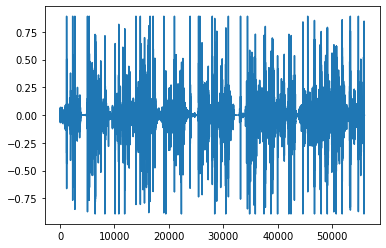

time: 10.5 s (started: 2023-01-22 18:34:55 +00:00)


In [ ]:
  import matplotlib.pyplot as plt
  (audio, motorseq)=create_random_tract(1400)
  print(motorseq.shape)
  print(audio.shape)
  plt.plot(audio)
  plt.show()
  # plt.plot(audio2)
  # plt.show()

In [ ]:
audio=create_random_tract(200)

time: 1.49 s (started: 2023-01-22 18:19:18 +00:00)


In [ ]:
audio2=tract_sequence_to_audio(get_random_motorseq(200), sr=16000)

time: 1.4 s (started: 2023-01-22 18:19:23 +00:00)


-0.9766511852432634
time: 920 µs (started: 2023-01-22 18:15:31 +00:00)


In [ ]:
print(audio)

[0 0 0 0 0 0 0]
time: 756 µs (started: 2023-01-22 18:17:18 +00:00)


<bound method Random.seed of <random.Random object at 0x2272010>>

In [ ]:
a=audio_list

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
gc.collect(0)
gc.collect(1)
gc.collect(2)

90

In [ ]:
for i in range(len(sizes)):
  np.save("/content/drive/MyDrive/seq_list_{}34".format(sizes[i]), seq_list_full[i].numpy())

time: 5.96 s (started: 2023-01-22 23:59:43 +00:00)


In [ ]:
#audio_list=pad_sequence(audio_list, batch_first=True)
np.save("/content/drive/MyDrive/audio_list23", audio_list_full.numpy())

time: 4.54 s (started: 2023-01-22 23:57:28 +00:00)


In [14]:
sizes=[35, 70, 140, 280, 420, 560, 700, 840, 1120, 1400]

In [15]:
seq_list_full=[None, None, None, None, None, None, None, None, None, None]
for i in range(len(sizes)):
  seq_list_full[i]=torch.tensor(np.load("/content/drive/MyDrive/seq_list_{}.npy".format(sizes[i])))

In [16]:
audio_list_full=torch.tensor(np.load("/content/drive/MyDrive/audio_list2.npy"))

In [ ]:
seq_list_numpy=[s.states.to_numpy() for s in seq_list]

In [ ]:
seq_list_torch=[torch.tensor(s) for s in seq_list_numpy]

In [ ]:
seq_list_torch_padded=pad_sequence(seq_list_torch, batch_first=True)


AttributeError: ignored

In [ ]:
np.save("/content/drive/MyDrive/seq_list2", seq_list_torch_padded.numpy())

In [ ]:
seq_list=np.load("/content/drive/MyDrive/seq_list.npy")

In [ ]:
audio_list=np.load("/content/drive/MyDrive/audio_list.npy")

In [ ]:
seq_list=torch.tensor(seq_list).to(device)
audio_list=torch.tensor(audio_list).to(device)

In [ ]:
audio_list_full=audio_list_full.to(device)

time: 1.61 s (started: 2023-01-23 00:30:13 +00:00)


In [17]:
#split_index=int(0.9*audio_list.size()[0])
seq_lists_train=[seq.to(device)[:270] for seq in seq_list_full]
seq_lists_test=[seq.to(device)[270:] for seq in seq_list_full]
#seq_list_train, seq_list_test=seq_list[:split_index], seq_list[split_index:]
#audio_indices_test=np.array(sum([list(range(300*a-30, 300*a)) for a in range(1, 11)], [])).astype(int)
audio_indices=torch.arange(0,3000)
audio_indices_train=audio_indices[(audio_indices%300)<270]
audio_indices_test=audio_indices[(audio_indices%300)>=270]
audio_list_train, audio_list_test=audio_list_full[audio_indices_train], audio_list_full[audio_indices_test]

In [ ]:
print(sum([[1, 2], [2,3], [17, 18]], []))

[1, 2, 2, 3, 17, 18]
time: 611 µs (started: 2023-01-23 00:52:09 +00:00)


In [18]:
class ListTensorDataset(TensorDataset):
  def __init__(self, input_tensors, target_tensors):
    print(len(input_tensors))
    print(target_tensors.size()[0])
    assert len(input_tensors)==target_tensors.size()[0], "Size mismatch"
    self.tensors=(input_tensors, target_tensors)
  def __len__(self):
    return len(self.tensors[0])

In [26]:
print()

[<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.T

In [19]:
train_dataset=ListTensorDataset(sum([list(seq.float().to(device)) for seq in seq_lists_train], []), audio_list_train.float().to(device))
train_dataloader=DataLoader(train_dataset, batch_size=18, num_workers=0)
test_dataset=ListTensorDataset(sum([list(seq.float().to(device)) for seq in seq_lists_test], []), audio_list_test.float().to(device))
test_dataloader=DataLoader(test_dataset, batch_size=16, num_workers=0)

2700
2700
300
300


In [ ]:
print(seq_list_torch_padded.size())

torch.Size([3000, 1400, 30])


In [ ]:
def findConvTransposeOutputLength(input_length, kernel_size, num):
  #L_out=(L_in−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1
  output_length=input_length
  for i in range(num):
    output_length=(output_length)*kernel_size
    

SyntaxError: ignored

In [ ]:
print(audio_list.size())

torch.Size([3000, 55874])


In [20]:
class VocalTractLabApproximator(nn.Module):
  def __init__(self, encoder_hidden_size, decoder_hidden_size, num_articulatory_parameters, input_embedding_size, lstm_output_seq_length, num_shuffle_upscales, shuffle_upscale_factor, initial_upscale_factor, output_size, dropout, audio_max_amplitude, upscale_mode="linear"):
    #Shape Dimensions: N=Batch Size, L=Length, E=Number of articulatory parameters, H_x=any sort of hidden/embedding/channel dimension
    super(VocalTractLabApproximator, self).__init__();
    upscale_factor=(output_size/(lstm_output_seq_length*initial_upscale_factor*shuffle_upscale_factor**num_shuffle_upscales))
    #Input Shape: N, L, E
    #Sequence "Embedding"- linear layer that takes in sequence
    self.dropout=nn.Dropout(dropout)
    self.articulatory_embedding=nn.Linear(num_articulatory_parameters, input_embedding_size)
    #Recurrent (take last entry): (N, L, H_1) -> (N, 1, H_2)
    #H_2 is very large
    self.encoder=nn.LSTM(input_embedding_size, encoder_hidden_size)
    self.decoder=nn.LSTM(encoder_hidden_size, decoder_hidden_size)
    self.decoder_hidden_size=decoder_hidden_size
    #Repeat Recurrent a few times
    #Upsample to audio length with PixelShuffle
    self.upscale_initial=nn.Upsample(scale_factor=initial_upscale_factor, mode=upscale_mode)
    self.hidden_upscaler=nn.Upsample(scale_factor=(shuffle_upscale_factor)**(2), mode="nearest")
    self.pixel_shuffle=nn.PixelShuffle(shuffle_upscale_factor)
    print(upscale_factor)
    self.upscale=nn.Upsample(scale_factor=upscale_factor, mode=upscale_mode)
    self.mid_shuffle_downscaler=nn.Linear(shuffle_upscale_factor**3, shuffle_upscale_factor)
    self.width_downscaler=nn.Linear(shuffle_upscale_factor, 1)
    self.num_shuffle_upscales=num_shuffle_upscales
    self.lstm_output_seq_length=lstm_output_seq_length
    self.output_linear=nn.Linear(self.decoder_hidden_size, 1)
    self.activation=nn.Tanh()
    self.audio_max_amplitude=audio_max_amplitude;
  def forward(self,x):
    batch_size=x.size()[0]
    #N, L, E, -> L, N, H_1
    embedded=self.dropout(self.articulatory_embedding(x)).transpose(0, 1)
    #L, N, H_1 -> 1, N, H_2
    encoded=self.encoder(embedded)
    hidden_state=(encoded[1][0][-1:], encoded[1][1][-1:])
    #1, N, H_2 -> L_2, N, H_3
    current_sequence=torch.zeros(self.lstm_output_seq_length, batch_size, self.decoder_hidden_size).to(device)
    for i in range(self.lstm_output_seq_length):
      decoded=self.decoder(current_sequence, hidden_state)
      current_sequence=current_sequence.clone()
      current_sequence[i]=decoded[0][-1]
    #L_2, N, H_3 -> N, H_4, L_3
    initial_upscaled=self.upscale_initial(current_sequence.transpose(0,1).transpose(1,2))
    hidden_upscaled=self.hidden_upscaler(initial_upscaled.transpose(1, 2)).transpose(1,2)
    #N, H_4, L_3 -> N, H_4, L_4, H_5
    pixel_shuffled=hidden_upscaled.unsqueeze(3)
    for i in range(self.num_shuffle_upscales):
 #     print(pixel_shuffled.size())
      pixel_shuffled=self.pixel_shuffle(pixel_shuffled.clone())
  #    pixel_shuffled=self.mid_shuffle_downscaler(self.hidden_upscaler(pixel_shuffled.transpose(1,2))).transpose(1,2)

    #N, H_4, L_4, H_5->N, H_3, L_4
    downscaled=self.width_downscaler(pixel_shuffled).squeeze(3)
#    print(downscaled.size())
    upscaled=self.upscale(downscaled)
    #N, H_3, L_4 -> N, L_4
  #  print(upscaled.size())
    output=self.activation(self.output_linear(upscaled.transpose(1, 2))).squeeze(2)*self.audio_max_amplitude
    # print(output.size())
    return output
  def train_model(self, train_dataloader, optimizer, loss_func):
    self.train()
    c=0;
    for batch, (x,y) in enumerate(train_dataloader):
      output=self(x)
      # print(output.size())
      # print(y.size())
      loss=loss_func(output, y)
      if(c%100==0):
        print(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      c+=1;
    

    



    


    



In [21]:
approximator=VocalTractLabApproximator(
    encoder_hidden_size=128,
    decoder_hidden_size=128,
    num_articulatory_parameters=30,
    input_embedding_size=512,
    lstm_output_seq_length=8,
    num_shuffle_upscales=1,
    shuffle_upscale_factor=16,
    initial_upscale_factor=16,
    output_size=55912,
    dropout=0.2,
    audio_max_amplitude=0.9
).to(device)

27.30078125


In [ ]:
torch.randn(3,3,3).squeeze(1).size()

torch.Size([3, 3, 3])

In [39]:
gc.collect(0)
gc.collect(1)
gc.collect(2)

5440

In [ ]:
print(torch.min(audio_list))

tensor(-0.8913, dtype=torch.float64)


In [ ]:
seq_list.size()

torch.Size([3000, 1400, 30])

In [40]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [23]:
epochs=300

In [24]:
for i in range(epochs):
  print("Epoch: {}".format(i))
  approximator.train_model(train_dataloader, 
                          torch.optim.Adam(approximator.parameters(), lr=0.00001), 
                          nn.L1Loss())

Epoch: 0
tensor(0.0979, grad_fn=<MeanBackward0>)


KeyboardInterrupt: ignored

In [ ]:
torch.save(approximator, "/content/drive/MyDrive/VocalTractLabapproximator_{}.pt".format(random.random()))

In [ ]:
import matplotlib.pyplot as plt;

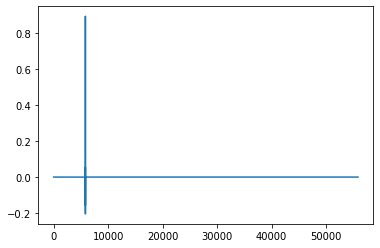

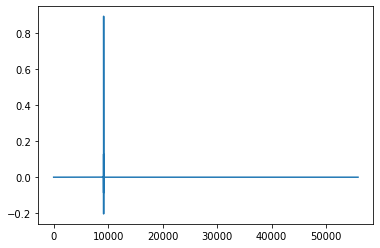

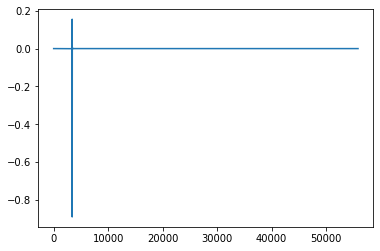

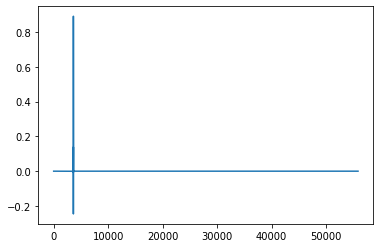

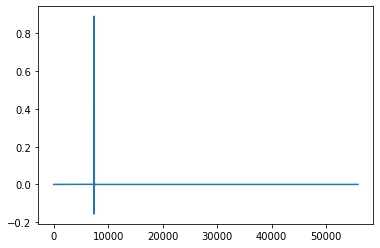

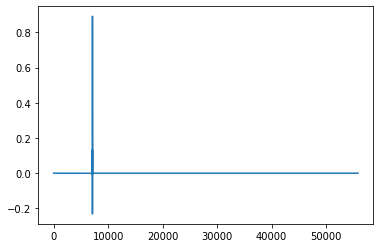

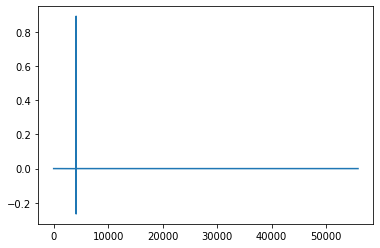

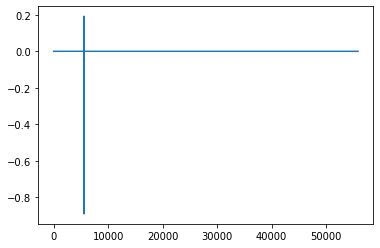

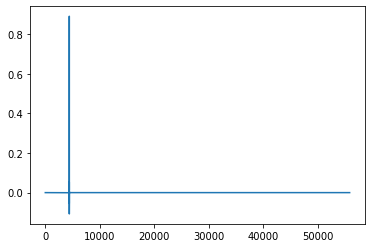

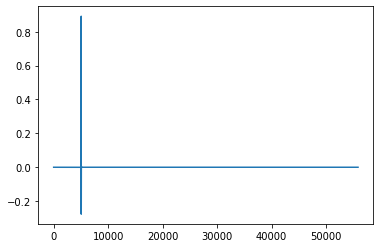

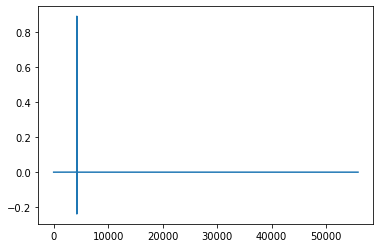

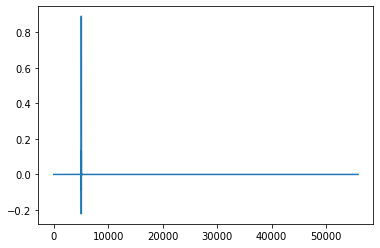

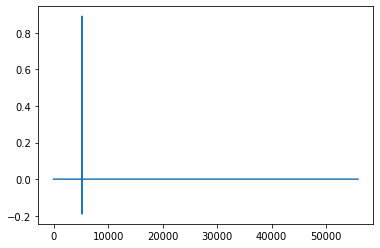

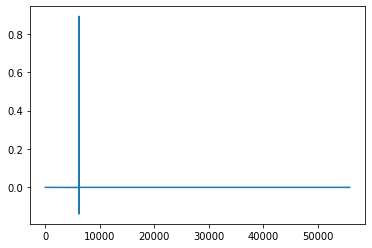

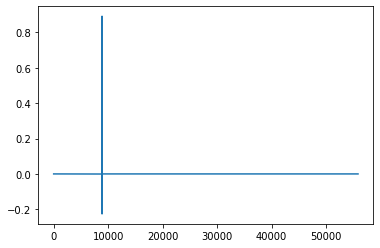

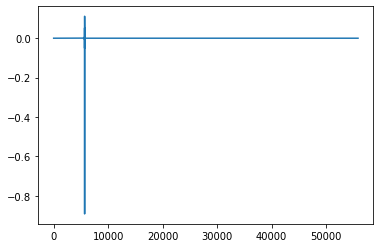

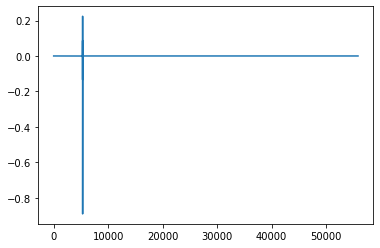

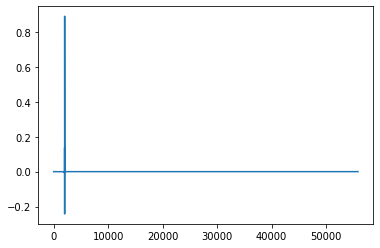

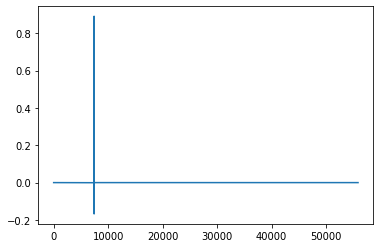

In [ ]:
with torch.no_grad():
  loss_func=nn.L1Loss()
  approximator.eval()
  losses=[]
  for batch, (x,y) in enumerate(test_dataloader):
    prediction=approximator(x)
    loss=loss_func(prediction, y)
    plt.plot(y[0].cpu().numpy())
    plt.show()
    losses.append(loss)

In [ ]:
print(losses)

[tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0023, device='cuda:0')]


In [ ]:
print(sum(losses)/len(losses))

tensor(0.0023, device='cuda:0')
